In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set the base path
base_path = '/content/drive/My Drive/assignment  4 /ml-100k/'

# Reading users file
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(base_path + 'u.user', sep='|', names=u_cols, encoding='latin-1')

# Reading data file
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(base_path + 'u.data', sep='\t', names=r_cols, encoding='latin-1')

# Reading items file
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv(base_path + 'u.item', sep='|', names=m_cols, usecols=range(5), encoding='latin-1')

# Merging data as one DataFrame
movie_ratings = pd.merge(movies, ratings)
lens = pd.merge(movie_ratings, users)

movie_idx = {}
idx_movie = {}
for i in movies.values:
    movie_idx[i[1]] = i[0]
    idx_movie[i[0]] = i[1]


Mounted at /content/drive


In [2]:
# unique users ids data
user_map = pd.Series(
    index=np.unique(lens['user_id']),
    data=np.arange(lens['user_id'].nunique()),
    name='user_map')

# unique movies ids data
movie_map = pd.Series(
    index=np.unique(lens['movie_id']),
    data=np.arange(lens['movie_id'].nunique()),
    name='movie_map')
# mapping unique users ids to the lens data
user_inds = lens['user_id'].map(user_map)
# mapping unique movies ids to the lens data
movie_inds = lens['movie_id'].map(movie_map)

# creating a pivot table of user_id, movie_id, and rating
rating_matrix = (
        pd.pivot_table(
            data=lens,
            values='rating',
            index=user_inds,
            columns=movie_inds,
        ).fillna(0).values
)
rating_matrix

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [3]:
# MatrixFactorization class
class MatrixFactorization():
    # constructor
    def __init__(self, rating_matrix, rating_matrix_val, k=5, lmbda=0.01, max_epochs=50, lr=0.1):
        '''
        rating_matrix: the matrix of rating (row: user, col: movie)
        k : int, default=2
            Number of latent features
        lmbda : float, default=0.01
            Regularization parameter
        max_epochs : int, default=15
            Max number of iterations to run
        lr: float, default:0.1
            Learning rate
        '''
        self.rating_matrix = rating_matrix
        self.rating_matrix_val = rating_matrix_val
        self.k = k
        self.lmbda = lmbda
        self.max_epochs = max_epochs
        self.lr = lr
        self.U = np.random.normal(scale=1./self.k, size=(rating_matrix.shape[0], self.k))
        self.V = np.random.normal(scale=1./self.k, size=(self.k, rating_matrix.shape[1]))
        self.b_u = np.zeros(rating_matrix.shape[0])
        self.b_i = np.zeros(rating_matrix.shape[1])
        self.b = np.mean(rating_matrix[np.where(rating_matrix != 0)])
        self.mean_squared_errors = []
        self.mean_squared_errors_val = []
    # fitting the model
    # The method fits the model by iterating through the specified number of epochs
    # and updating model parameters using stochastic gradient descent.
    def fit(self):
        for it in range(self.max_epochs):
            for i in range(len(self.rating_matrix)):
                for j in range(len(self.rating_matrix[i])):
                    if self.rating_matrix[i][j] > 0:
                        eij = self.rating_matrix[i][j] - (self.predict_rating_user_movie(i, j))
                        self.b_u[i] += self.lr * (eij - self.lmbda * self.b_u[i])
                        self.b_i[j] += self.lr * (eij - self.lmbda * self.b_i[j])
                        self.U[i,:] += self.lr * (eij * self.V[:,j] - self.lmbda * self.U[i,:])
                        self.V[:,j] += self.lr * (eij * self.U[i,:] - self.lmbda * self.V[:,j])

            self.mean_squared_errors.append(self.mse_training(self.rating_matrix, self.predict()))
            self.mean_squared_errors_val.append(self.mse_validation(self.rating_matrix, self.rating_matrix_val, self.predict()))

    # reporting model's mse using the training set
    # Calculates Mean Squared Error (MSE) for training sets.
    def mse_training(self, true_rating, pred_rating):
        '''
        pred_matrix: the predict matrix of rating (row: user, col: movie)
        return: mean squared error
        '''
        error = 0
        for rt, rp in zip(true_rating, pred_rating):
            for vt, vp in zip(rt, rp):
                if vt > 0:
                    error += pow(vt - vp, 2)
        return np.sqrt(error)

    # reporting model's mse using testing set
    # Calculates Mean Squared Error (MSE) for training set.
    def mse_validation(self, true_rating, test_rating, pred_rating):
        '''
        pred_matrix: the predict matrix of rating (row: user, col: movie)
        return: mean squared error
        '''
        error = 0
        for rt, rtt, rp in zip(true_rating, test_rating, pred_rating):
            for vt, vtt, vp in zip(rt, rtt, rp):
                if vt == -1:
                    error += pow(vtt - vp, 2)
        return np.sqrt(error)

    # predicting the user's movie rating
    def predict_rating_user_movie(self, i, j):
        '''
        i: user row
        j: movie col
        '''
        return self.b + self.b_u[i] + self.b_i[j] + np.dot(self.U[i,:],self.V[:,j])

    # rating prediction
    # Predicts the rating for a given user i and movie j.
    def predict(self):
        '''
        return: rating prediction
        '''
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:, ] + np.dot(self.U, self.V)

    # plotting model's loss
    def plot_loss(self):
        iters = [i for i in range(self.max_epochs)]
        plt.xlabel("Iterations")
        plt.ylabel("Mean Squared Error")
        plt.plot(iters, self.mean_squared_errors)
        plt.plot(iters, self.mean_squared_errors_val)

    # mean square error result
    def mse_result(self):
        return self.mean_squared_errors[-1]

In [4]:
# splitting data into train and validation sets
def create_training_validation_set(rating_matrix):
    r_test = rating_matrix.copy()
    r_train = rating_matrix.copy()

    for r in range(0,r_train.shape[0]):
        for c in range(0, r_train.shape[1]):
            if np.random.rand()<0.2 and r_train[r,c] != 0:
                r_train[r,c] = -1

    return np.asarray(r_train), r_test

rating_matrix_training, rating_matrix_test = create_training_validation_set(rating_matrix)# splitting data into train and validation sets
def create_training_validation_set(rating_matrix):
    r_test = rating_matrix.copy()
    r_train = rating_matrix.copy()

    for r in range(0,r_train.shape[0]):
        for c in range(0, r_train.shape[1]):
            if np.random.rand()<0.2 and r_train[r,c] != 0:
                r_train[r,c] = -1

    return np.asarray(r_train), r_test

rating_matrix_training, rating_matrix_test = create_training_validation_set(rating_matrix)

In [5]:
# finding top movies
def find_top_close_movies(movie_idx, idx_movie, pred_rating, movie_name):
    movie_to_check = pred_rating[:, movie_idx[movie_name]] # 'Star Wars (1977)'
    df1 = pd.DataFrame(pred_rating)
    df2 = pd.DataFrame(movie_to_check)
    df = df1.corrwith(df2[0], axis=0)
    results = df.sort_values(ascending=False).head(4)[1:]
    for i, j in zip(list(results.index), results.values):
        print(idx_movie[i], j)

In [6]:
# recommending movies
def recommend_movies_to_user(idx_movie, pred_rating, user_id):
    user_to_check = pred_rating[user_id, :]
    df1 = pd.DataFrame(pred_rating)
    df2 = pd.DataFrame(user_to_check)
    df = df1.corrwith(df2[0], axis=1)
    results = df.sort_values(ascending=False).head(6)[1:]

    movie_index = []
    for i in results.index:
        movie_index.append(pred_rating[i,:])

    movie_index = np.asarray(movie_index)

    movie_index = np.mean(movie_index, axis=0)

    results = pd.DataFrame(movie_index).sort_values(by=0, ascending=False).head(5)

    for i, j in zip(list(results.index), results.values):

        if user_to_check[i]:
            try:
                print(idx_movie[i])
            except Exception as e:
                pass

In [7]:
# grid search function
def grid_search(parameters):
    min_mse = 1000
    best_parameters=[]
    # loop over all parameters
    for k in range( len( parameters ) ) :
        # model with the kth parameter
        model = MatrixFactorization(rating_matrix_training, rating_matrix_test,  parameters[k][0], parameters[k][1], max_epochs=parameters[k][2], lr=parameters[k][3])
        # fit model
        model.fit()
        # predict labels
        pred = model.predict()
        # measure mse
        curr_mse=model.mse_validation(rating_matrix_training, rating_matrix_test, pred)
        # find the best parameters with the minimum mse
        if min_mse > curr_mse :
            min_mse = curr_mse
            best_parameters=[parameters[k][0],parameters[k][1],parameters[k][2],parameters[k][3]]

    print( "Minimum mse achieved by our model through grid searching : ", min_mse )
    return best_parameters


In [21]:
import itertools

# Input your parameters with a smaller set
k= [20,30]
lmbda= [0.02, 0.05]
max_epochs=[20,30]
lr=[0.005, 0.1]

# Merge all parameters into one list
parameters = [k, lmbda, max_epochs, lr]
parameters = list(itertools.product(*parameters))

# Grid search
best_parameters = grid_search(parameters)

<ipython-input-3-fe1bbf76347a>:41: RuntimeWarning: overflow encountered in multiply
  self.V[:,j] += self.lr * (eij * self.U[i,:] - self.lmbda * self.V[:,j])
<ipython-input-3-fe1bbf76347a>:40: RuntimeWarning: overflow encountered in multiply
  self.U[i,:] += self.lr * (eij * self.V[:,j] - self.lmbda * self.U[i,:])
<ipython-input-3-fe1bbf76347a>:40: RuntimeWarning: invalid value encountered in add
  self.U[i,:] += self.lr * (eij * self.V[:,j] - self.lmbda * self.U[i,:])
<ipython-input-3-fe1bbf76347a>:41: RuntimeWarning: invalid value encountered in subtract
  self.V[:,j] += self.lr * (eij * self.U[i,:] - self.lmbda * self.V[:,j])
<ipython-input-3-fe1bbf76347a>:57: RuntimeWarning: overflow encountered in scalar power
  error += pow(vt - vp, 2)
<ipython-input-3-fe1bbf76347a>:38: RuntimeWarning: invalid value encountered in scalar add
  self.b_u[i] += self.lr * (eij - self.lmbda * self.b_u[i])
<ipython-input-3-fe1bbf76347a>:80: RuntimeWarning: invalid value encountered in scalar add
  retu

Minimum mse achieved by our model through grid searching :  130.1081580805969


In [22]:
# report best parameters
best_parameters

[30, 0.02, 30, 0.005]

In [27]:
# pass the best parameters to MatrixFactorization model
best_model = MatrixFactorization(rating_matrix_training, rating_matrix_test,  k=30, lmbda=0.02, max_epochs=30, lr=0.005)
# fit model
best_model.fit()
# predict labels
pred = best_model.predict()
# report best model mse score
best_model.mse_validation(rating_matrix_training, rating_matrix_test, pred)


129.91742653347592

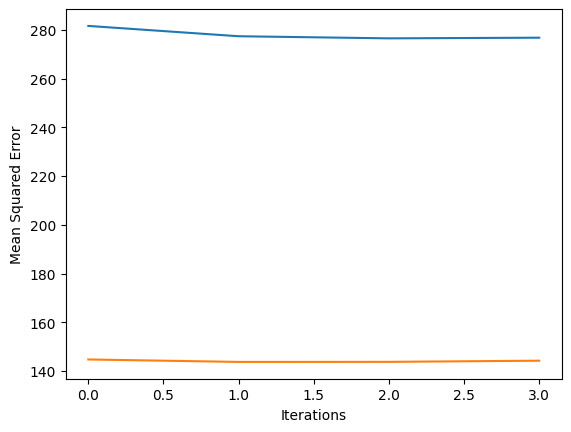

In [24]:
# plot the model loss
best_model.plot_loss()


In [28]:
# report the best model mse_results
best_model.mse_result()

233.02791791985473

In [29]:
find_top_close_movies(movie_idx, idx_movie, pred, 'Star Wars (1977)')

Die Hard 2 (1990) 0.9919982227731706
Rich Man's Wife, The (1996) 0.99134487006391
Die Hard (1988) 0.9910472145708009


In [30]:
recommend_movies_to_user(idx_movie, pred, 32)

Spy Hard (1996)
Monty Python and the Holy Grail (1974)
In the Name of the Father (1993)
Santa Clause, The (1994)
Seven (Se7en) (1995)


In [31]:
from sklearn.cluster import KMeans
import matplotlib
# loading data
ta_data = pd.read_csv('tripadvisor_review.csv')
# features
X = ta_data.drop('User ID', axis=1)
X.head()

,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
0,0.93,1.8,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
1,1.02,2.2,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
2,1.22,0.8,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
3,0.45,1.8,0.29,0.57,0.46,1.52,3.18,2.96,1.57,2.86
4,0.51,1.2,1.18,0.57,1.54,2.02,3.18,2.78,1.18,2.54


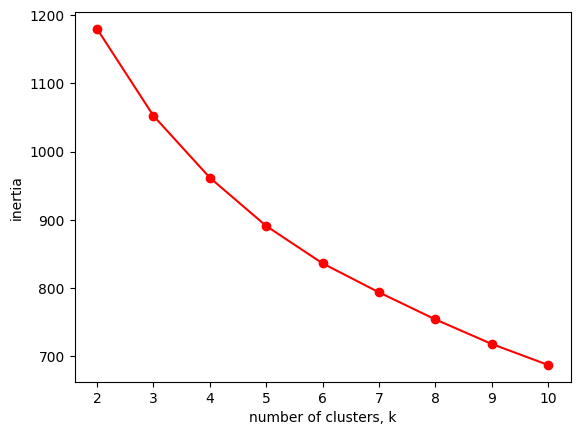

In [32]:
ks = range(2, 11)
inertias = []
for k in ks:
    ###### YOUR CODE STARTS HERE #####
    # create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    # fit model to X
    model.fit(X)
    # append the inertia to the list of inertias
    inertias.append(model.inertia_)
    ###### YOUR CODE ENDS HERE #####

plt.plot(ks, inertias, '-o', color='red')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


In [33]:
from sklearn.decomposition import PCA
import matplotlib
import seaborn as sns

# create a PCA instance: pca
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
# save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)
PCA_components.rename(columns = {0:'Component1', 1:'Component2'}, inplace = True)

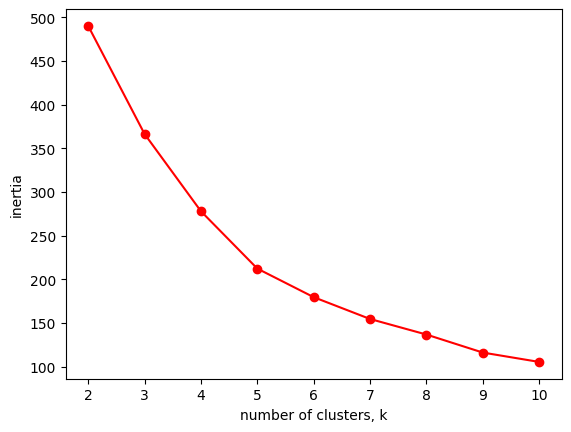

In [34]:
from sklearn.cluster import KMeans

ks = range(2, 11)
inertias = []
for k in ks:
    ###### YOUR CODE STARTS HERE #####
    # create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=42)

    # fit model to PCA_components
    model.fit(PCA_components)

    # append the inertia to the list of inertias
    inertias.append(model.inertia_)
    ###### YOUR CODE ENDS HERE #####

plt.plot(ks, inertias, '-o', color='red')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


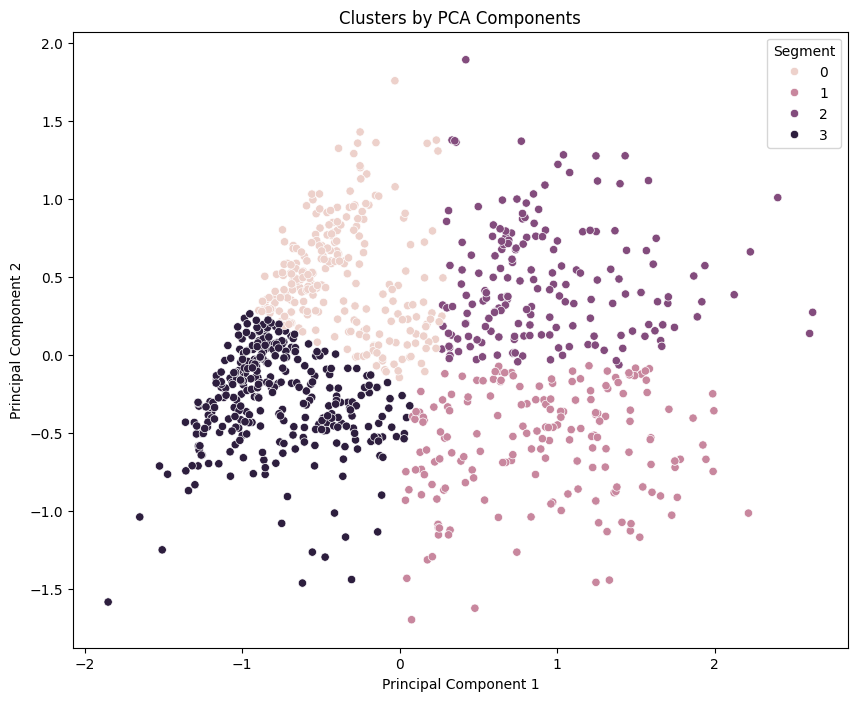

In [35]:
# Pass the best number of clusters (n_clusters) as you see fit from the previous Elbow Method plot
###### YOUR CODE STARTS HERE #####
kmeans_pca = KMeans(n_clusters=4, random_state=42)  # Replace 4 with the optimal value you found
###### YOUR CODE ENDS HERE #####

# Fit the KMeans model on the PCA components
kmeans_pca.fit(PCA_components)

# Concatenate data with the PCA components
df_pca_kmeans = pd.concat([X, PCA_components], axis=1)

# Assign cluster labels to the DataFrame
df_pca_kmeans['Segment'] = kmeans_pca.labels_

# Extract PCA component values for plotting
x_axis = df_pca_kmeans['Component1']
y_axis = df_pca_kmeans['Component2']

# Cluster plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue=df_pca_kmeans['Segment'])
plt.title('Clusters by PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
